In [50]:
# import pymc3 as pm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

## General Introduction 

### General settings

In [283]:
countries = ['France', 'Germany', 'United Kingdom']  #, 'Italy', 'Spain']
split_year = 2012  # trainset until split_year
nb_steps = 20
nb_sim = 1000

### Some functions 

In [284]:
def generate_path_AR(initial_value, beta, intercept, sigma, nb_steps, nb_sim):
    """
    Function that given beta, intercept and sigma generates paths. 

    :params initial_value: np.array
        Initial value a time t=0
    :params beta: float
        Parameter of order 1 AR model
    :params intercept: float
        Intercept
    :params sigma: float
        Standard deviation paameter
    :params nb_steps: int 
        Nb of tim steps to perform for each path.
    :params nb_sim: int 
        Nb of paths to generate
    """
    # random part 
    output = np.random.normal(0, scale=sigma, size=(nb_sim, nb_steps+1))

    # initialization 
    output[:, 0] = initial_value + np.zeros(nb_sim)

    # perform auto regression on each path
    for i in range(nb_steps):
        output[:, i+1] += beta * output[:, i] + intercept

    return output


### Explore data

Import dataset 

In [285]:
# import data 
df = pd.read_csv('./../data/World Energy Consumption.csv')

# keep only data from some european countries
df = df[df.country.isin(countries)]

# keep only some relevant columns for first experiment
df = df[['year', 'population', 'gdp', 'electricity_demand', 'country']]

# handle missing value 
df.dropna(inplace=True)

# get general info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 7322 to 20583
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                87 non-null     int64  
 1   population          87 non-null     float64
 2   gdp                 87 non-null     float64
 3   electricity_demand  87 non-null     float64
 4   country             87 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 4.1+ KB


In [286]:
# observe a sample of the dataset
df.sample(5)

,year,population,gdp,electricity_demand,country
7794,2013,81680592.0,3.553715e+12,598.96,Germany
7793,2012,81545568.0,3.536438e+12,599.85,Germany
20572,2007,61260680.0,2.267380e+12,398.19,United Kingdom
20570,2005,60383740.0,2.160946e+12,403.74,United Kingdom
7777,1996,81300864.0,2.402606e+12,545.42,Germany


Rescale data 

In [287]:
# rescale data 
df['gdp'] /= 1e12
df['population'] /= 1e7
df['electricity_demand'] /= 100

Change gdp in gdp_per_hab

In [288]:
df["gdp_per_hab"] = df["gdp"] / df["population"]
df.drop("gdp", axis=1, inplace=True)

Visualize the data 

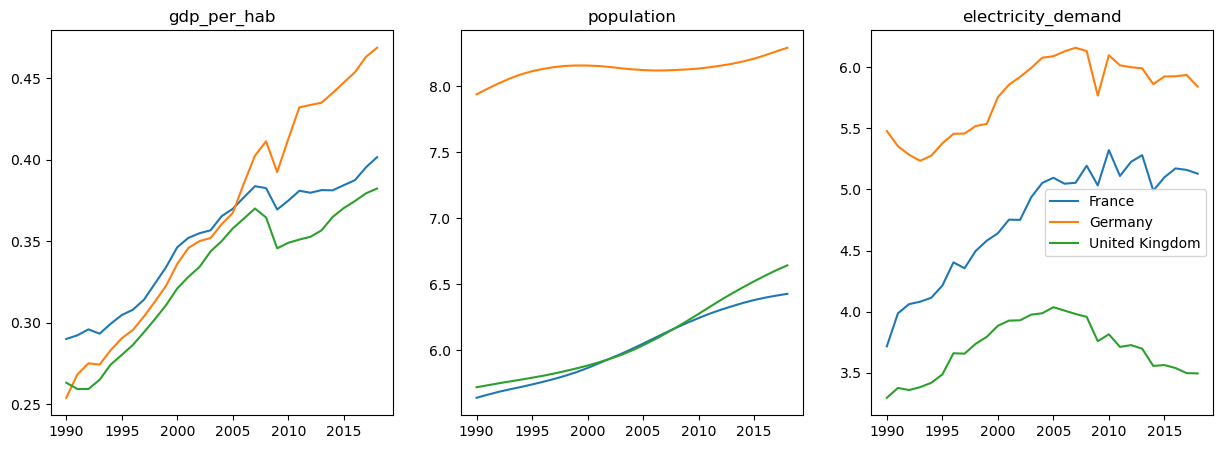

In [289]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for country in countries:
    df_country = df.loc[df.country==country].sort_values(by="year")
    for index, column in enumerate(['gdp_per_hab', 'population', 'electricity_demand']):
        ax[index].plot(df_country.year, df_country[[column]], label=country)
        ax[index].set_title(column)

plt.legend()
plt.show()

### Train-test split 

In [290]:
df_train = df.loc[df.year <= split_year]
df_test = df.loc[df.year > split_year]

# Expérience 1 - Modélisation DBN à trois variables

## Description du modèle.

Pour commencer, nous allons implémenter un Gaussian Dynamic Bayesian Network. 

Pour la strcuture de notre réseau nous supposerons notamment: 
1) Pop(t+1) ne dépend que de Pop(t)
2) GDP(t+1) ne dépend que de GDP(t+1)
3) La Demand(t) dépend de Pop(t) et GDP(t)

En outre, nous supposerons une distribution gaussienne de bonsn ombre de procédés: 
1) $ Pop(t+1) \sim N(\beta_{pop}.Pop(t), \sigma_{pop}^2) $ - Modèle AR 
2) $ GDP(t+1) \sim N(\beta_{gdp}.GDP(t), \sigma_{gdp}^2) $ - Modèle AR 
3) $ Demand(t) \sim N(\beta_{1}.Pop(t) + \beta_{2}.GDP(t), \sigma^2) $ - Bayesian linear regression 

Notons tout de même que, par ex, la demande n'est normale qu'étant donné Pop(t) et GDP(t). La réelle distribution n'est donc pas nécessairement gaussienne. Nous voulons implémenter trois différentes approches: 

1) Statistiques "classiques": estimations des différents paramètres dans le cadre de la statistique classique (e.g. par maximum de vraisemblance)
2) Estimation bayésiennes des paramètres: estimations des différents paramètres dans le cadre de la statistique bayésienne (i.e. avec la définition d'un prior)
3) Sampling a posteriori (bayésiens): sampling à partir des différentes distributions a posteriori de tous les paramètres. 

Ainsi, les prior à définir sont: 
- $ \beta_{pop} \sim $  
- $ \sigma_{pop} \sim $  
- $ \beta_{GDP} \sim $  
- $ \sigma_{GDP} \sim $  
- $ \beta_{1} \sim $  
- $ \beta_{2} \sim $
- $ \sigma \sim $  

C'est ici tout l'intérêt de l'approche bayésienne. Etant donné la faible quantité de données, on ne peut pas se permettre de ne laisser parler que les données. Il faut aussi laisser parler les experts à travers le choix d'une bonne structure et de bons priors. Dans notre cas, les priors non-infoprmatifs devraient être à proscrire. En effet, vu la faible quantité de données, l'estimation n'en serait que plus mauvaise. 

## Modèle "Statistique classique"

Dans ce modèle, nous estimons tous les paramètres par la méthode du maximum de vraisemblance. Nous commençons toutefois par séparer les time-series par pays. 

In [291]:
# initialize dict for having df for each country 
df_train_per_country = {}
df_test_per_country = {}

for country in countries:

    # get trainsets per country
    df_country_train = df_train.loc[df_train.country==country].sort_values("year")
    df_train_per_country[country] = df_country_train

    # get test set per country
    df_country_test = df_test.loc[df_test.country==country].sort_values("year")
    df_test_per_country[country] = df_country_test

### Estimation des paramètres du modèle AR du PIB par habitant

In [292]:
# x and y for linear regression 
x = []
y = []

for country in countries:
    gdp_country = df_train_per_country.get(country)
    x = x + list(gdp_country.gdp_per_hab[:-1])
    y = y + list(gdp_country.gdp_per_hab[1:])

x = np.array(x)
y = np.array(y)

In [293]:
# perform AR
x_ = x[:, None]
res = sm.OLS(y,x_).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.497e+05
Date:                Wed, 13 Mar 2024   Prob (F-statistic):                   5.20e-111
Time:                        18:34:05   Log-Likelihood:                          233.12
No. Observations:                  66   AIC:                                     -464.2
Df Residuals:                      65   BIC:                                     -462.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [294]:
# get beta
beta_gdp = res.params[0]

# compute sigma_gdp (from MLE)
sigma_gdp = np.sqrt(np.sum(np.square(res.resid)) / res.nobs)

print("beta_gdp: ", beta_gdp)
print("sigma_gdp: ", sigma_gdp)

beta_gdp:  1.0158495331624982
sigma_gdp:  0.007075969825855313


Text(0.5, 1.0, 'PIB par habitant en France')

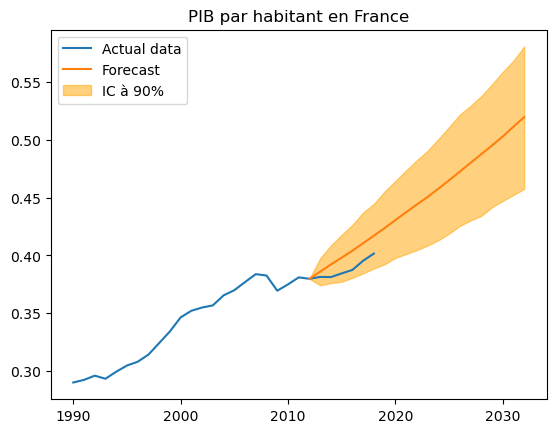

In [295]:
# get last value for france
df_france = df.loc[df.country=='France']
initial_gdp = df_france.loc[df_france.year == split_year].gdp_per_hab.values

paths = generate_path_AR(initial_gdp, beta_gdp, 0, sigma_gdp, nb_steps, nb_sim)
mean_path = np.mean(paths, axis=0)
perc_path95 = np.percentile(paths, q=95, axis=0)
perc_path5 = np.percentile(paths, q=5, axis=0)
sup_path = perc_path95
inf_path = perc_path5

plt.plot(df_france.year, df_france.gdp_per_hab, label="Actual data")
plt.plot(np.arange(split_year, split_year+nb_steps+1), mean_path, label="Forecast")
plt.fill_between(np.arange(split_year, split_year+nb_steps+1), 
                 inf_path, 
                 sup_path, 
                 color="orange", 
                 alpha=0.5, 
                 label="IC à 90%")

plt.legend(loc="upper left")
plt.title("PIB par habitant en France")

### Estimation des paramètres du modèle AR population

In [296]:
# x and y for linear regression 
x = []
y = []

for country in countries:
    pop_country = df_train_per_country.get(country)
    x = x + list(pop_country.population[:-1])
    y = y + list(pop_country.population[1:])

x = np.array(x)
y = np.array(y)

In [297]:
# perform AR
x_ = x[:, None]
res = sm.OLS(y,x_).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.839e+06
Date:                Wed, 13 Mar 2024   Prob (F-statistic):                   1.43e-168
Time:                        18:34:06   Log-Likelihood:                          170.29
No. Observations:                  66   AIC:                                     -338.6
Df Residuals:                      65   BIC:                                     -336.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [298]:
# get beta
beta_pop = res.params[0]

# compute sigma_gdp (from MLE)
sigma_pop = np.sqrt(np.sum(np.square(res.resid)) / res.nobs)

print("beta_pop: ", beta_pop)
print("sigma_pop: ", sigma_pop)

beta_pop:  1.0032350074516903
sigma_pop:  0.01833116193101885


Text(0.5, 1.0, 'Population en France')

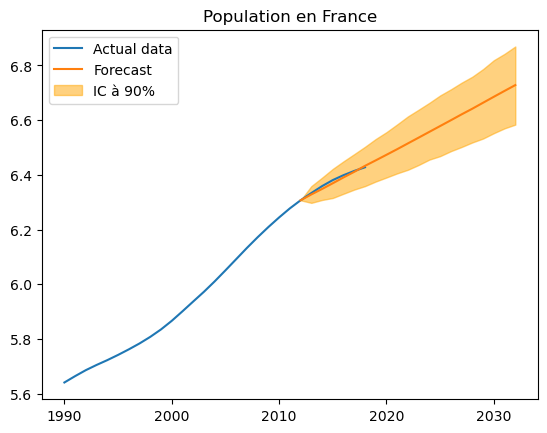

In [299]:
# get last value for france
df_france = df.loc[df.country=='France']
initial_pop = df_france.loc[df_france.year == split_year].population.values

paths = generate_path_AR(initial_pop, beta_pop, 0, sigma_pop, nb_steps, nb_sim)
mean_path = np.mean(paths, axis=0)
perc_path95 = np.percentile(paths, q=95, axis=0)
perc_path5 = np.percentile(paths, q=5, axis=0)
sup_path = perc_path95
inf_path = perc_path5

plt.plot(df_france.year, df_france.population, label="Actual data")
plt.plot(np.arange(split_year, split_year+nb_steps+1), mean_path, label="Forecast")
plt.fill_between(np.arange(split_year, split_year+nb_steps+1), 
                 inf_path, 
                 sup_path, 
                 color="orange", 
                 alpha=0.5, 
                 label="IC à 90%")

plt.legend(loc="upper left")
plt.title("Population en France")

### Estimation des paramètres du modèle de consommation 

In [300]:
res = smf.ols(formula="electricity_demand ~ gdp_per_hab + population", data=df_train).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     electricity_demand   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     154.3
Date:                Wed, 13 Mar 2024   Prob (F-statistic):           1.31e-25
Time:                        18:34:07   Log-Likelihood:                -29.979
No. Observations:                  69   AIC:                             65.96
Df Residuals:                      66   BIC:                             72.66
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.9865      0.414     -4.793      

In [301]:
# get beta
intercept, beta1, beta2 = res.params

# compute sigma_gdp (from MLE)
sigma = np.sqrt(np.sum(np.square(res.resid)) / res.nobs)

print("beta1 gdp per habitant: ", beta1)
print("beta2, population: ", beta2)
print("Intercept: ", intercept)
print("sigma: ", sigma)

beta1 gdp per habitant:  6.870544232541409
beta2, population:  0.6601036753691417
Intercept:  -1.9864841468369003
sigma:  0.37364258026788727


Generate some predictions 

In [302]:
# generate gdp per inhabitants paths 
gdp_paths = generate_path_AR(
    initial_value=initial_gdp, 
    beta=beta_gdp, 
    intercept=0, 
    sigma=sigma_gdp, 
    nb_steps=nb_steps, 
    nb_sim=nb_sim
)

# generate gdp per inhabitants paths 
pop_paths = generate_path_AR(
    initial_value=initial_pop, 
    beta=beta_pop, 
    intercept=0, 
    sigma=sigma_pop, 
    nb_steps=nb_steps, 
    nb_sim=nb_sim
)

In [303]:
# generate electricty demand paths 
beta1_mat = beta1 + np.zeros((nb_sim, nb_steps+1))
beta2_mat = beta2 + np.zeros((nb_sim, nb_steps+1))
intercept_mat = intercept + np.zeros((nb_sim, nb_steps+1))
noise = np.random.normal(loc=0, scale=sigma, size=(nb_sim, nb_steps+1))

# compute paths 
paths = beta1_mat * gdp_paths + beta2_mat * pop_paths + intercept_mat + noise

# start with initial demand
initial_demand = df_france.loc[df_france.year == split_year].electricity_demand.values
paths[:, 0] = initial_demand 

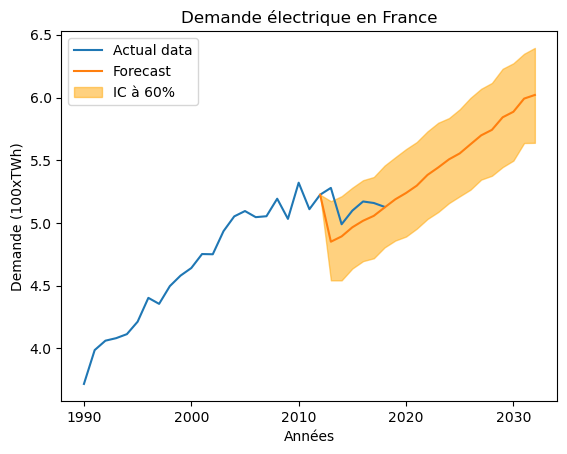

In [304]:
# get last value for france
df_france = df.loc[df.country=='France']

mean_path = np.mean(paths, axis=0)
perc_path_sup = np.percentile(paths, q=80, axis=0)
perc_path_inf = np.percentile(paths, q=20, axis=0)
sup_path = perc_path_sup
inf_path = perc_path_inf

plt.plot(df_france.year, df_france.electricity_demand, label="Actual data")
plt.plot(np.arange(split_year, split_year+nb_steps+1), mean_path, label="Forecast")
plt.fill_between(np.arange(split_year, split_year+nb_steps+1), 
                 inf_path, 
                 sup_path, 
                 color="orange", 
                 alpha=0.5, 
                 label="IC à 60%")

plt.legend(loc="upper left")
plt.title("Demande électrique en France")
plt.xlabel("Années")
plt.ylabel("Demande (100xTWh)")
plt.show()

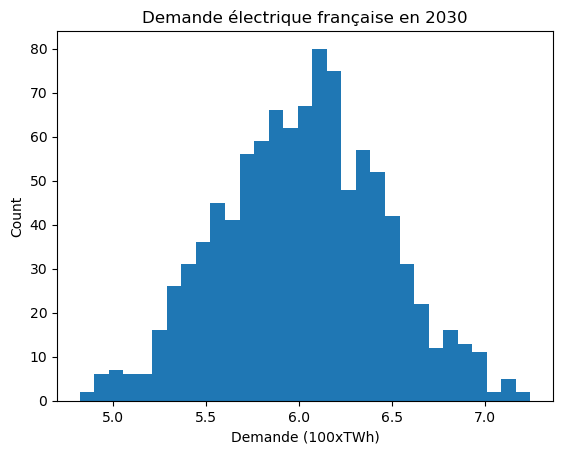

In [305]:
plt.hist(paths[:, -1], bins=int(np.sqrt(nb_sim)))

plt.title("Demande électrique française en 2030")
plt.xlabel("Demande (100xTWh)")
plt.ylabel("Count")
plt.show()